# Import Libraries

In [39]:
from datetime import datetime
import numpy as np
import pandas as pd
pd.set_option("display.max.columns", None)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
import plotly.graph_objects as go

from tapy import Indicators

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score, 
    recall_score,
    precision_score,
    classification_report,
    confusion_matrix
)

import xgboost
from xgboost import XGBClassifier

from keras.models import Sequential
from keras import regularizers
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout, GRU
from keras.optimizers import Adam
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.utils import to_categorical

# D1 Timeframe

In [3]:
# read in 2019 full year 1 hour timeframe price data
df_d1_feature = pd.read_csv('../data/df_d1_feature.csv', index_col=0)
df_d1_feature.index = pd.to_datetime(df_d1_feature.index)
df_d1_feature = df_d1_feature.dropna()
df_d1_feature.head()

,open,high,low,close,results,day_of_wk,shift_01,close_shift_01_dist,shift_02,close_shift_02_dist,shift_03,close_shift_03_dist,shift_05,close_shift_05_dist,shift_08,close_shift_08_dist,shift_13,close_shift_13_dist,shift_21,close_shift_21_dist,shift_34,close_shift_34_dist,shift_55,close_shift_55_dist,shift_89,close_shift_87_dist,shift_02m01,shift_03m02,shift_03m01,shift_05m03,shift_05m02,shift_05m01,shift_08m05,shift_08m03,shift_08m02,shift_08m01,shift_13m08,shift_13m05,shift_13m03,shift_13m02,shift_13m01,shift_21m13,shift_21m08,shift_21m05,shift_21m03,shift_21m02,shift_21m01,shift_34m21,shift_34m13,shift_34m08,shift_34m05,shift_34m03,shift_34m02,shift_34m01,shift_55m34,shift_55m21,shift_55m13,shift_55m08,shift_55m05,shift_55m03,shift_55m02,shift_55m01,shift_89m55,shift_89m34,shift_89m21,shift_89m13,shift_89m08,shift_89m05,shift_89m03,shift_89m02,shift_89m01,sma_02,close_sma_02_dist,sma_03,close_sma_03_dist,sma_05,close_sma_05_dist,sma_08,close_sma_08_dist,sma_13,close_sma_13_dist,sma_21,close_sma_21_dist,sma_34,close_sma_34_dist,sma_55,close_sma_55_dist,sma_89,close_sma_89_dist,sma_03m02,sma_05m03,sma_05m02,sma_08m05,sma_08m03,sma_08m02,sma_13m08,sma_13m05,sma_13m03,sma_13m02,sma_21m13,sma_21m08,sma_21m05,sma_21m03,sma_21m02,sma_34m21,sma_34m13,sma_34m08,sma_34m05,sma_34m03,sma_34m02,sma_55m34,sma_55m21,sma_55m13,sma_55m08,sma_55m05,sma_55m03,sma_55m02,sma_89m55,sma_89m34,sma_89m21,sma_89m13,sma_89m08,sma_89m05,sma_89m03,sma_89m02,diff,gain,loss,rsi_14,rsi_14_shift_01,rsi_14_shift_01_dist,rsi_14_shift_02,rsi_14_shift_02_dist,rsi_14_shift_03,rsi_14_shift_03_dist,rsi_14_shift_05,rsi_14_shift_05_dist,rsi_14_shift_08,rsi_14_shift_08_dist,rsi_14_shift_13,rsi_14_shift_13_dist,rsi_14_shift_21,rsi_14_shift_21_dist,rsi_14_shift_02m01,rsi_14_shift_03m02,rsi_14_shift_03m01,rsi_14_shift_05m03,rsi_14_shift_08m05,rsi_14_shift_08m03,rsi_14_shift_08m02,rsi_14_shift_08m01,rsi_14_shift_13m08,rsi_14_shift_13m05,rsi_14_shift_13m03,rsi_14_shift_13m02,rsi_14_shift_13m01,rsi_14_shift_21m13,rsi_14_shift_21m08,rsi_14_shift_21m05,rsi_14_shift_21m03,rsi_14_shift_21m02,rsi_14_shift_21m01,rsi_14_sma_02,rsi_14_sma_03,rsi_14_sma_05,rsi_14_sma_08,rsi_14_sma_13,rsi_14_sma_21,rsi_14_sma_03m02,rsi_14_sma_05m03,rsi_14_sma_05m02,rsi_14_sma_08m05,rsi_14_sma_08m03,rsi_14_sma_08m02,rsi_14_sma_13m08,rsi_14_sma_13m05,rsi_14_sma_13m03,rsi_14_sma_13m02,rsi_14_sma_21m13,rsi_14_sma_21m08,rsi_14_sma_21m05,rsi_14_sma_21m03,rsi_14_sma_21m02
2003-04-15,1.0772,1.0822,1.0738,1.0802,1,1,1.0773,2.9,1.0754,4.8,1.0755,4.7,1.0781,2.1,1.0644,15.8,1.0914,-11.2,1.0525,27.7,1.0993,-19.1,1.0729,7.3,1.0476,32.6,-1.9,0.1,-1.8,2.6,2.7,0.8,-13.7,-11.1,-11.0,-12.9,27.0,13.3,15.9,16.0,14.1,-38.9,-11.9,-25.6,-23.0,-22.9,-24.8,46.8,7.9,34.9,21.2,23.8,23.9,22.0,-26.4,20.4,-18.5,8.5,-5.2,-2.6,-2.5,-4.4,-25.3,-51.7,-4.9,-43.8,-16.8,-30.5,-27.9,-27.8,-29.7,1.07875,1.45,1.077633,2.566667,1.07732,2.88,1.075587,4.6125,1.075538,4.661538,1.074671,5.528571,1.076515,3.685294,1.078116,2.083636,1.074019,6.180899,-1.116667e+00,-0.313333,-1.43,-1.7325,-2.045833,-3.1625,-0.049038,-1.781538,-2.094872,-3.211538,-0.867033,-0.916071,-2.648571,-2.961905,-4.078571,1.843277,0.976244,0.927206,-0.805294,-1.118627,-2.235294,1.601658,3.444935,2.577902,2.528864,0.796364,0.483030,-0.633636,-4.097263,-2.495605,-0.652327,-1.519360,-1.568399,-3.300899,-3.614232,-4.730899,0.0029,0.0029,0.0000,59.593582,54.539032,-5.054550,51.063056,-8.530526,51.241771,-8.351811,55.685796,-3.907787,36.309679,-23.283904,70.687929,11.094347,22.555143,-37.038439,-3.475976,4.622739,1.146764,4.444024,-19.376117,-14.932093,-14.753378,-18.229353,34.378251,15.002134,19.446158,19.624873,16.148897,-48.132786,-13.754535,-33.130652,-28.686628,-28.507913,-31.983889,57.066307,55.065223,54.450024,52.171192,50.922280,51.468761,-2.001084,-0.615199,-2.616283,-2.278833,-2.894032,-4.895115,-1.248911,-3.527744,-4.142943,-6.144027,0.546481,-0.702431,-2.981263,-3.596462,-5.597546
2003-04-16,1.0803,1.0979,1.0800,1.0954,0,2,1.0802,15.2,1.0773,18.1,1.0754,20.0,1.0782,17.2

In [4]:
df_d1_feature.shape

(5211, 183)

In [5]:
df_d1_feature.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5211 entries, 2003-04-15 to 2019-12-23
Columns: 183 entries, open to rsi_14_sma_21m02
dtypes: float64(181), int64(2)
memory usage: 7.3 MB


In [6]:
non_feature = ['open', 'high', 'low', 'close', 'results',
               'shift_01', 'shift_02', 'shift_03', 'shift_05', 
               'shift_08', 'shift_13', 'shift_21', 'shift_34',
               'shift_55', 'shift_89'
               'sma_02', 'sma_03', 'sma_05', 'sma_08', 
               'sma_13', 'sma_21', 'sma_34', 'sma_55', 'sma_89',
               'diff','gain','loss']
features = [col for col in df_d1_feature.columns if col not in non_feature]

X = df_d1_feature[features]
y = df_d1_feature['results']

## Train Test Split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False )

In [8]:
X_train.head()

,day_of_wk,close_shift_01_dist,close_shift_02_dist,close_shift_03_dist,close_shift_05_dist,close_shift_08_dist,close_shift_13_dist,close_shift_21_dist,close_shift_34_dist,close_shift_55_dist,shift_89,close_shift_87_dist,shift_02m01,shift_03m02,shift_03m01,shift_05m03,shift_05m02,shift_05m01,shift_08m05,shift_08m03,shift_08m02,shift_08m01,shift_13m08,shift_13m05,shift_13m03,shift_13m02,shift_13m01,shift_21m13,shift_21m08,shift_21m05,shift_21m03,shift_21m02,shift_21m01,shift_34m21,shift_34m13,shift_34m08,shift_34m05,shift_34m03,shift_34m02,shift_34m01,shift_55m34,shift_55m21,shift_55m13,shift_55m08,shift_55m05,shift_55m03,shift_55m02,shift_55m01,shift_89m55,shift_89m34,shift_89m21,shift_89m13,shift_89m08,shift_89m05,shift_89m03,shift_89m02,shift_89m01,sma_02,close_sma_02_dist,close_sma_03_dist,close_sma_05_dist,close_sma_08_dist,close_sma_13_dist,close_sma_21_dist,close_sma_34_dist,close_sma_55_dist,close_sma_89_dist,sma_03m02,sma_05m03,sma_05m02,sma_08m05,sma_08m03,sma_08m02,sma_13m08,sma_13m05,sma_13m03,sma_13m02,sma_21m13,sma_21m08,sma_21m05,sma_21m03,sma_21m02,sma_34m21,sma_34m13,sma_34m08,sma_34m05,sma_34m03,sma_34m02,sma_55m34,sma_55m21,sma_55m13,sma_55m08,sma_55m05,sma_55m03,sma_55m02,sma_89m55,sma_89m34,sma_89m21,sma_89m13,sma_89m08,sma_89m05,sma_89m03,sma_89m02,rsi_14,rsi_14_shift_01,rsi_14_shift_01_dist,rsi_14_shift_02,rsi_14_shift_02_dist,rsi_14_shift_03,rsi_14_shift_03_dist,rsi_14_shift_05,rsi_14_shift_05_dist,rsi_14_shift_08,rsi_14_shift_08_dist,rsi_14_shift_13,rsi_14_shift_13_dist,rsi_14_shift_21,rsi_14_shift_21_dist,rsi_14_shift_02m01,rsi_14_shift_03m02,rsi_14_shift_03m01,rsi_14_shift_05m03,rsi_14_shift_08m05,rsi_14_shift_08m03,rsi_14_shift_08m02,rsi_14_shift_08m01,rsi_14_shift_13m08,rsi_14_shift_13m05,rsi_14_shift_13m03,rsi_14_shift_13m02,rsi_14_shift_13m01,rsi_14_shift_21m13,rsi_14_shift_21m08,rsi_14_shift_21m05,rsi_14_shift_21m03,rsi_14_shift_21m02,rsi_14_shift_21m01,rsi_14_sma_02,rsi_14_sma_03,rsi_14_sma_05,rsi_14_sma_08,rsi_14_sma_13,rsi_14_sma_21,rsi_14_sma_03m02,rsi_14_sma_05m03,rsi_14_sma_05m02,rsi_14_sma_08m05,rsi_14_sma_08m03,rsi_14_sma_08m02,rsi_14_sma_13m08,rsi_14_sma_13m05,rsi_14_sma_13m03,rsi_14_sma_13m02,rsi_14_sma_21m13,rsi_14_sma_21m08,rsi_14_sma_21m05,rsi_14_sma_21m03,rsi_14_sma_21m02
2003-04-15,1,2.9,4.8,4.7,2.1,15.8,-11.2,27.7,-19.1,7.3,1.0476,32.6,-1.9,0.1,-1.8,2.6,2.7,0.8,-13.7,-11.1,-11.0,-12.9,27.0,13.3,15.9,16.0,14.1,-38.9,-11.9,-25.6,-23.0,-22.9,-24.8,46.8,7.9,34.9,21.2,23.8,23.9,22.0,-26.4,20.4,-18.5,8.5,-5.2,-2.6,-2.5,-4.4,-25.3,-51.7,-4.9,-43.8,-16.8,-30.5,-27.9,-27.8,-29.7,1.07875,1.45,2.566667,2.88,4.6125,4.661538,5.528571,3.685294,2.083636,6.180899,-1.116667e+00,-0.313333,-1.43,-1.7325,-2.045833,-3.1625,-0.049038,-1.781538,-2.094872,-3.211538,-0.867033,-0.916071,-2.648571,-2.961905,-4.078571,1.843277,0.976244,0.927206,-0.805294,-1.118627,-2.235294,1.601658,3.444935,2.577902,2.528864,0.796364,0.483030,-0.633636,-4.097263,-2.495605,-0.652327,-1.519360,-1.568399,-3.300899,-3.614232,-4.730899,59.593582,54.539032,-5.054550,51.063056,-8.530526,51.241771,-8.351811,55.685796,-3.907787,36.309679,-23.283904,70.687929,11.094347,22.555143,-37.038439,-3.475976,4.622739,1.146764,4.444024,-19.376117,-14.932093,-14.753378,-18.229353,34.378251,15.002134,19.446158,19.624873,16.148897,-48.132786,-13.754535,-33.130652,-28.686628,-28.507913,-31.983889,57.066307,55.065223,54.450024,52.171192,50.922280,51.468761,-2.001084,-0.615199,-2.616283,-2.278833,-2.894032,-4.895115,-1.248911,-3.527744,-4.142943,-6.144027,0.546481,-0.702431,-2.981263,-3.596462,-5.597546
2003-04-16,2,15.2,18.1,20.0,17.2,30.0,6.9,34.9,-5.5,20.3,1.0384,57.0,-2.9,-1.9,-4.8,2.8,0.9,-2.0,-12.8,-10.0,-11.9,-14.8,23.1,10.3,13.1,11.2,8.3,-28.0,-4.9,-17.7,-14.9,-16.8,-19.7,40.4,12.4,35.5,22.7,25.5,23.6,20.7,-25.8,14.6,-13.4,9.7,-3.1,-0.3,-2.2,-5.1,-36.7,-62.5,-22.1,-50.1,-27.0,-39.8,-37.0,-38.9,-41.8,1.08780,7.60,11.100000,14.64,16.0625,19.330769,19.066667,19.047059,16.914545,20.740449,-3.500000e+00,-3.540000,-7.04,-1.4225,-4.962500,-8.4625,-3

In [9]:
print(X_train.shape)
print(X_test.shape)

(3908, 158)
(1303, 158)


In [10]:
y_train.value_counts(normalize=True)

1    0.412487
2    0.366428
0    0.221085
Name: results, dtype: float64

In [11]:
y_test.value_counts(normalize=True)

0    0.547966
1    0.228703
2    0.223331
Name: results, dtype: float64

## Standard Scaler

In [12]:
ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.transform(X_test)

## Logistic Regression

### un-randomized train set

In [20]:
# Gridsearch parameters
logr_params = {'C':np.logspace(-1,10),
               'class_weight': [None, 'balanced'],
               'penalty':['l1', 'l2'],}

# Score base on roc_auc
logr_gridsearch = RandomizedSearchCV(LogisticRegression(solver='liblinear'), 
                              logr_params,
                              cv=5,
                              verbose=1,                              
                              n_jobs=-1)

logr_gridsearch = logr_gridsearch.fit(X_train_ss, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   18.6s finished


In [21]:
print(f"cv best score mean: {round(logr_gridsearch.best_score_, 4)}")
print(f"cv best score std: {round(logr_gridsearch.cv_results_['std_test_score'][logr_gridsearch.best_index_], 4)}")
print(f"cv best param: {logr_gridsearch.best_params_}")
print("")
print(f"train set score: {round(logr_gridsearch.score(X_train_ss, y_train), 4)}")
print(f"validation set score: {round(logr_gridsearch.score(X_test_ss, y_test), 4)}")

cv best score mean: 0.3877
cv best score std: 0.0253
cv best param: {'penalty': 'l1', 'class_weight': None, 'C': 0.47148663634573934}

train set score: 0.4255
validation set score: 0.2341


In [22]:
logr_pred = logr_gridsearch.predict(X_test_ss)
cm = confusion_matrix(y_test, logr_pred)
cm_df = pd.DataFrame(cm, columns=['pred 0', 'pred 1', 'pred 2'], index=['actual 0', 'actual 1', 'actual 2'])
cm_df

,pred 0,pred 1,pred 2
actual 0,1,712,1
actual 1,0,296,2
actual 2,2,281,8


In [23]:
cm_df.loc['actual 1'][1]/(cm_df['pred 1'].sum())

0.22963537626066718

In [24]:
cm_df.loc['actual 2'][2]/(cm_df['pred 2'].sum())

0.7272727272727273

In [25]:
(cm_df.loc['actual 1'][1]+cm_df.loc['actual 2'][2])/((cm_df['pred 1'].sum())+(cm_df['pred 2'].sum()))

0.23384615384615384

## Random Forest

### un-randomized train set

In [16]:
rf_params = {
    'n_estimators': list(range(400, 601)),
    'min_samples_split': list(range(2, 9)),
    'max_features' : list(range(1, X_train_ss.shape[1])),
    'max_depth': list(range(2, 10)),
    'class_weight': [None, 'balanced', 'balanced_subsample']
}

rf_gridsearch = RandomizedSearchCV(RandomForestClassifier(), 
                              rf_params,
                              cv=5, 
                              verbose=1,
                              n_iter=10,
                              n_jobs=-1)

rf_gridsearch = rf_gridsearch.fit(X_train_ss, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 14.8min finished


In [26]:
print(f"cv best score mean: {round(rf_gridsearch.best_score_, 4)}")
print(f"cv best score std: {round(rf_gridsearch.cv_results_['std_test_score'][rf_gridsearch.best_index_], 4)}")
print(f"cv best param: {rf_gridsearch.best_params_}")
print("")
print(f"train set score: {round(rf_gridsearch.score(X_train_ss, y_train), 4)}")
print(f"validation set score: {round(rf_gridsearch.score(X_test_ss, y_test), 4)}")

cv best score mean: 0.38
cv best score std: 0.0553
cv best param: {'n_estimators': 470, 'min_samples_split': 5, 'max_features': 18, 'max_depth': 9, 'class_weight': 'balanced'}

train set score: 0.8439
validation set score: 0.495


In [27]:
rf_pred = rf_gridsearch.predict(X_test_ss)
cm = confusion_matrix(y_test, rf_pred)
cm_df = pd.DataFrame(cm, columns=['pred 0', 'pred 1', 'pred 2'], index=['actual 0', 'actual 1', 'actual 2'])
cm_df

,pred 0,pred 1,pred 2
actual 0,506,172,36
actual 1,155,96,47
actual 2,150,98,43


In [28]:
cm_df.loc['actual 1'][1]/(cm_df['pred 1'].sum())

0.26229508196721313

In [29]:
cm_df.loc['actual 2'][2]/(cm_df['pred 2'].sum())

0.3412698412698413

In [30]:
(cm_df.loc['actual 1'][1]+cm_df.loc['actual 2'][2])/((cm_df['pred 1'].sum())+(cm_df['pred 2'].sum()))

0.28252032520325204

## Extremely Randomized Trees

### un-randomized train set

In [31]:
et_params = {
    'n_estimators': list(range(400, 601)),
    'min_samples_split': list(range(2, 9)),    
    'max_features' : list(range(1, X_train_ss.shape[1])),
    'max_depth': list(range(2, 10)),
    'class_weight': [None, 'balanced', 'balanced_subsample']
}

et_gridsearch = RandomizedSearchCV(ExtraTreesClassifier(), 
                              et_params,
                              cv=5, 
                              verbose=1, 
                              n_jobs=-1)

et_gridsearch = et_gridsearch.fit(X_train_ss, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.8min finished


In [32]:
print(f"cv best score mean: {round(et_gridsearch.best_score_, 4)}")
print(f"cv best score std: {round(et_gridsearch.cv_results_['std_test_score'][et_gridsearch.best_index_], 4)}")
print(f"cv best param: {et_gridsearch.best_params_}")
print("")
print(f"train set score: {round(et_gridsearch.score(X_train_ss, y_train), 4)}")
print(f"validation set score: {round(et_gridsearch.score(X_test_ss, y_test), 4)}")

cv best score mean: 0.3723
cv best score std: 0.0309
cv best param: {'n_estimators': 441, 'min_samples_split': 2, 'max_features': 89, 'max_depth': 3, 'class_weight': None}

train set score: 0.4849
validation set score: 0.2318


In [33]:
et_pred = et_gridsearch.predict(X_test_ss)
cm = confusion_matrix(y_test, et_pred)
cm_df = pd.DataFrame(cm, columns=['pred 0', 'pred 1', 'pred 2'], index=['actual 0', 'actual 1', 'actual 2'])
cm_df

,pred 0,pred 1,pred 2
actual 0,0,706,8
actual 1,0,290,8
actual 2,0,279,12


## XGB

### un-randomized train set

In [34]:
xgc_param = [{'subsample' : [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
              'reg_lambda' : np.logspace(-5,5),
              'reg_alpha' : np.logspace(-5,5),
              'max_depth' : list(range(2, 10)),
              'learning_rate' : [0.0001],
              'gamma' : np.logspace(-5,5),
              'colsample_bytree' : np.logspace(-5,5), }]

xgc_gridsearch = RandomizedSearchCV(XGBClassifier(), 
                              xgc_param,
                              cv=5, 
                              verbose=1, 
                              n_jobs=-1)

xgc_gridsearch = xgc_gridsearch.fit(X_train_ss, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   24.1s finished


In [35]:
print(f"cv best score mean: {round(xgc_gridsearch.best_score_, 4)}")
print(f"cv best score std: {round(xgc_gridsearch.cv_results_['std_test_score'][xgc_gridsearch.best_index_], 4)}")
print(f"cv best param: {xgc_gridsearch.best_params_}")
print("")
print(f"train set score: {round(xgc_gridsearch.score(X_train_ss, y_train), 4)}")
print(f"validation set score: {round(xgc_gridsearch.score(X_test_ss, y_test), 4)}")

cv best score mean: 0.4125
cv best score std: 0.0005
cv best param: {'subsample': 0.5, 'reg_lambda': 2.559547922699533e-05, 'reg_alpha': 0.07543120063354623, 'max_depth': 6, 'learning_rate': 0.0001, 'gamma': 24420.53094548655, 'colsample_bytree': 0.7906043210907702}

train set score: 0.4125
validation set score: 0.2287


In [36]:
xgc_pred = xgc_gridsearch.predict(X_test_ss)
cm = confusion_matrix(y_test, xgc_pred)
cm_df = pd.DataFrame(cm, columns=['pred 0', 'pred 1', 'pred 2'], index=['actual 0', 'actual 1', 'actual 2'])
cm_df

,pred 0,pred 1,pred 2
actual 0,0,714,0
actual 1,0,298,0
actual 2,0,291,0


## FNN

### un-randomized train set

In [37]:
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

In [40]:
model = Sequential()
model.add(Dense(X_train_ss.shape[1], 
                input_shape= (X_train_ss.shape[1],),
                activation='relu',
                kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(3, activation='softmax'))

In [41]:
model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(lr = .0005), 
              metrics=['categorical_accuracy'])

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')

In [42]:
history = model.fit(X_train_ss, y_train_cat, 
                    validation_data=(X_test_ss, y_test_cat), 
                    epochs=50, batch_size=256,verbose=1,
                    callbacks=[early_stop])

Epoch 1/50
16/16 [==============================] - 0s 11ms/step - loss: 2.6317 - categorical_accuracy: 0.3907 - val_loss: 2.7216 - val_categorical_accuracy: 0.2655
Epoch 2/50
16/16 [==============================] - 0s 3ms/step - loss: 2.4681 - categorical_accuracy: 0.4266 - val_loss: 2.5460 - val_categorical_accuracy: 0.2763
Epoch 3/50
16/16 [==============================] - 0s 3ms/step - loss: 2.3413 - categorical_accuracy: 0.4573 - val_loss: 2.4400 - val_categorical_accuracy: 0.2886
Epoch 4/50
16/16 [==============================] - 0s 3ms/step - loss: 2.2277 - categorical_accuracy: 0.4637 - val_loss: 2.3437 - val_categorical_accuracy: 0.2916
Epoch 5/50
16/16 [==============================] - 0s 3ms/step - loss: 2.1274 - categorical_accuracy: 0.4831 - val_loss: 2.2510 - val_categorical_accuracy: 0.3024
Epoch 6/50
16/16 [==============================] - 0s 3ms/step - loss: 2.0333 - categorical_accuracy: 0.4880 - val_loss: 2.1643 - val_categorical_accuracy: 0.3131
Epoch 7/50
16/1

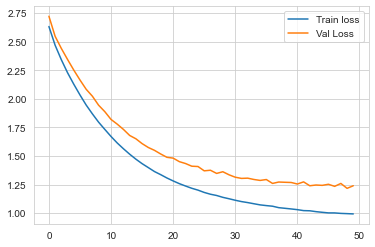

In [43]:
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend();

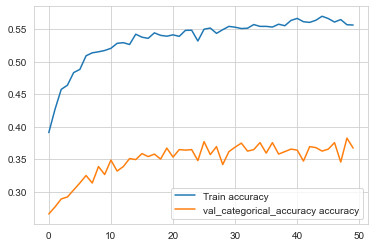

In [47]:
plt.plot(history.history['categorical_accuracy'], label='Train accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='val_categorical_accuracy accuracy')
plt.legend();

In [48]:
fnn_pred = model.predict_classes(X_test_ss)
cm = confusion_matrix(y_test, fnn_pred)
cm_df = pd.DataFrame(cm, columns=['pred 0', 'pred 1', 'pred 2'], index=['actual 0', 'actual 1', 'actual 2'])
cm_df

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


,pred 0,pred 1,pred 2
actual 0,240,456,18
actual 1,64,214,20
actual 2,74,193,24
